# COMPARAÇÃO DE MODELOS DE REDES NEURAIS ARTIFICIAIS PARA A PREDIÇÃO DA IRRADIÂNCIA SOLAR NA GERAÇÃO DE ENERGIA FOTOVOLTAICA

**Autores:** 
Victor H. Wentz$^1$
Joylan N. Maciel$^2$

$^1$victorhwentz@gmail.com
$^2$joylan.maciel@unila.edu.br


>Resumo:  Fatores climáticos não previsíveis promovem oscilações na geração de energia solar fotovoltaica. Enquanto diversas pesquisas propõem métodos de predição, poucas os comparam com o mesmo conjunto de dados. Este estudo avalia a acurácia de predição da irradiância solar empregando diferentes modelos de Redes Neurais Artificiais. Os resultados indicam que a estrutura de camadas das redes neurais, os distintos horizontes de predição e da irradiância solar influenciam na precisão dos modelos.  

Este notebook tem como proposito apresentar de forma simplificada todo o processo para a finalização do artigo,
deste a criação do dataset de treino/teste até a finalização com gráficos de geração. Utilizando como framework a biblioteca [PyTorch](https://pytorch.org/).
Tentarei apresentar de forma didatica e sequencial de todo o processo.

<div class="alert alert-success"><strong>NOTE:</strong> As variaveis definidas neste notebook <tt><strong>não</strong></tt>
    corresponde com as utilizadas no arquivo original, tambem não utilizarem GPU neste notebook, caso queria saber 
    como usar, entrar neste <a href='https://pytorch.org/docs/stable/notes/cuda.html'>Link</a>.</div>

# Sumário
1. Importação dos dados brutos
    1. Selecionando o intervalo de tempo
    2. Criação de novos atributos
    3. Concatenando os Atributos previsores com a variavel GHI
2. Inicio do PyTorch
    1. Classe DataSet
    2. Classe Module
3. Treino
    1. Definição dos parametros de treino
    2. Colocando a maquina para aprender
4. Teste
    1. Metricas de Erro
5. Gráficos
    1. Geração de novos gráficos de predição
    2. Comparando modelos

# Importação dos dados brutos

Os dados brutos estão divididos em 2 arquivos distinto, o primeiro folsom_weather possui os dados meterologicos dos anos de
2014 até 2016 com intervalo de 1 minuto, ja o arquivo folsom_irradiance possui os dados de radiação(global, difusa e direta). Portanto devemos fazer a importação dos 2 arquivos, selecionar o intervalo de tempo apropriado, concatenar e por fim, separar em um dataset pra treino e outro para teste.

In [1]:
#bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
dataWeather = pd.read_csv("../Data/Folsom_weather.csv", index_col = 0 ,parse_dates = True) 
dataIrra = pd.read_csv("../Data/Folsom_irradiance.csv", index_col = 0 ,parse_dates = True)

In [3]:
dataWeather.head()

,air_temp,relhum,press,windsp,winddir,max_windsp,precipitation
timeStamp,,,,,,,
2014-01-02 08:00:00,7.32,56.56,1010.0,1.80,43.61,3.7,0.0
2014-01-02 08:01:00,7.26,56.82,1010.0,2.00,48.40,3.1,0.0
2014-01-02 08:02:00,7.20,56.96,1010.0,1.90,31.80,3.7,0.0
2014-01-02 08:03:00,7.14,57.12,1010.0,1.44,38.98,2.5,0.0
2014-01-02 08:04:00,7.08,57.36,1010.0,1.84,34.21,2.8,0.0


In [4]:
#Vamos adicionar 2 atributos no DataFrame dataWeather, que são os atributos de tempo
dataWeather["mes"] = dataWeather.index.month
dataWeather["hora"] = dataWeather.index.hour 
dataWeather["min"] = dataWeather.index.minute

In [5]:
dataWeather.head()

,air_temp,relhum,press,windsp,winddir,max_windsp,precipitation,mes,hora,min
timeStamp,,,,,,,,,,
2014-01-02 08:00:00,7.32,56.56,1010.0,1.80,43.61,3.7,0.0,1,8,0
2014-01-02 08:01:00,7.26,56.82,1010.0,2.00,48.40,3.1,0.0,1,8,1
2014-01-02 08:02:00,7.20,56.96,1010.0,1.90,31.80,3.7,0.0,1,8,2
2014-01-02 08:03:00,7.14,57.12,1010.0,1.44,38.98,2.5,0.0,1,8,3
2014-01-02 08:04:00,7.08,57.36,1010.0,1.84,34.21,2.8,0.0,1,8,4


In [6]:
dataIrra.head()

,ghi,dni,dhi
timeStamp,,,
2014-01-02 08:00:00,0.0,0.0,0.0
2014-01-02 08:01:00,0.0,0.0,0.0
2014-01-02 08:02:00,0.0,0.0,0.0
2014-01-02 08:03:00,0.0,0.0,0.0
2014-01-02 08:04:00,0.0,0.0,0.0


In [7]:
# Como queremos fazer a predição de ghi, iremos selecionar apenas ele.
# dataIrra = dataIrra[["ghi"]]
dataIrra.drop(["dni","dhi"], inplace = True, axis = 1)

In [8]:
dataIrra.head()

,ghi
timeStamp,
2014-01-02 08:00:00,0.0
2014-01-02 08:01:00,0.0
2014-01-02 08:02:00,0.0
2014-01-02 08:03:00,0.0
2014-01-02 08:04:00,0.0


In [9]:
#Agora concatenamos os 2 DataFrame
dataFinal = pd.concat([dataWeather,dataIrra], axis = 1)

In [10]:
missing = dataFinal.isna()
dataFinal = dataFinal.interpolate('linear')

In [11]:
dataFinal.isna().sum()

air_temp         0
relhum           0
press            0
windsp           0
winddir          0
max_windsp       0
precipitation    0
mes              0
hora             0
min              0
ghi              0
dtype: int64

In [12]:
#Selecionando o intervalo
dataFinal = dataFinal[dataFinal.index.minute % 5 == 0] # Seleciona um item a cada 5 minutos

In [13]:
trainSize = int(len(dataFinal) * 0.98) # Selecionar os 98% primeiros dados para treino

In [14]:
dataTrain = dataFinal[:trainSize]
dataTest = dataFinal[trainSize:]

In [15]:
print(f"Tamanho do dataset(5 minutos): {len(dataFinal)}")
print(f"Tamanho do Treino: {len(dataTrain)}")
print(f"Tamanho do Teste: {len(dataTest)}")

Tamanho do dataset(5 minutos): 310464
Tamanho do Treino: 304254
Tamanho do Teste: 6210


Agora que temos os 2 DataFrame para treino e teste, vamos entrar no mundo do PyTorch, poderiamos fazer extração
de caracteristicas nos DataFrame, mas esse não é e nem foi o escopo da pesquisa.

# Inicio Pytorch

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings("ignore")

Para realizer o melhor uso do PyTorch, precisamos criar uma classe [DataSet](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) que carregue nossos dados para um [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [17]:
#Classe DataSet
class dataSet():
    
    """
    dataFrame: DataFrame a ser utilizado
    norm: Normalização dos dados.
    
    A função __getitem__ é responsavel de fazer a coleta dos dados
    
    A função __len__ retorna o tamanho dos dados.
    
    """
    
    def __init__(self, dataFrame, norm = True): #inicialização da classe
        
        self.data = dataFrame
        
        if norm == True:
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            self.data = scaler.fit_transform(self.data)
            
    def __getitem__(self,idx): 
        features = self.data[idx][0:10] #features
        label = self.data[idx][-1:] #ghi
        
        features = torch.from_numpy(features.astype(np.float32))
        label = torch.from_numpy(label.astype(np.float32))
        
        return features, label
    
    def __len__(self):
        return len(self.data)

Poderiamos extender a classe a cima para incluir diferentes tipos de normalização.

In [18]:
trainDataSet = dataSet(dataTrain) 
testDataSet = dataSet(dataTest)

In [19]:
trainDataSet[0]

(tensor([-1.2660,  0.1072,  1.2865,  0.5649, -1.6588,  1.2525, -0.0729, -1.6187,
         -0.5058, -1.5932]), tensor([-0.7105]))

In [20]:
#Classe Module define a arquitetura do modelo que iremos utilizar. neste caso vamos utilizar um modelo geral
#que possa ser inicializado com a arquitetura que preferir.
class PvModel(nn.Module):
    """
    input_feature(int): Quantidade de atributos previsores
    output_feature(int): Saida da rede
    layers_dims(list): Lista com a quantidade de neuronios em cada camada oculta 
    p: Probabilidade do dropout acontecer.
    """
    def __init__(self, input_feature, output_feature, layers_dims, p = 0.3):
        super(PvModel,self).__init__() #super inicialização
        
        layerlist = []
        count = 0
        for i in layers_dims:
            layerlist.append(nn.Linear(input_feature,i))
            nn.init.kaiming_normal_(layerlist[count].weight)
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.Dropout(p))
            input_feature = i
            count += 3 
            
        layerlist.append(nn.Linear(layers_dims[-1], output_feature))
        nn.init.kaiming_normal_(layerlist[count].weight)
        
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, X):
        X = self.layers(X)
        return X

In [21]:
#Dicionario com hiperparemetros.
args = {"Epocas": 10 ,   #Numero de epocas 
       "Lr": 1e-3 ,    # Taxa de aprendizado
       "num_work": 0 ,  #Processos
       "wd": 5e-4, # Weight decay
       "batchSize": 64 # Tamanho do batch
       }

In [22]:
#DataLoaders
trainDataLoader = DataLoader(trainDataSet,
                            batch_size = args["batchSize"],
                            shuffle = True, 
                            num_workers=args["num_work"])

testDataLoader = DataLoader(testDataSet,
                            batch_size = args["batchSize"],
                            shuffle = False, 
                            num_workers=args["num_work"])

In [23]:
#Rede qualquer
layers = [15,25,34,35]
in_f = len(trainDataSet[0][0])
out_f = 1
model = PvModel(in_f,out_f,layers)

In [24]:
model

PvModel(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=15, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=15, out_features=25, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=25, out_features=34, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=34, out_features=35, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=35, out_features=1, bias=True)
  )
)

In [25]:
#Criterio e Otimizador
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(),lr=args["Lr"],weight_decay=args["wd"])

In [26]:
#Treino
train_loss = []
val_loss = []

for epo in range(args["Epocas"]):
    trainEpo = []
    valEpo = []
    
    #Train Model
    model.train()
    for batch, (X_train, y_train) in enumerate(trainDataLoader):
        optimizer.zero_grad()
        #forward
        y_hat = model(X_train)
        loss = torch.sqrt(criterion(y_hat,y_train))
        trainEpo.append(loss.data)
        
        #backprop
        
        loss.backward()
        optimizer.step()
        
    
    #Eval
    model.eval()
    with torch.no_grad():
        for X_test, y_test in testDataLoader:
            y_hat = model(X_test)
            loss = torch.sqrt(criterion(y_hat,y_test))
            
            valEpo.append(loss.data)
            
    trainEpo = np.asarray(trainEpo)
    valEpo = np.asarray(valEpo)
    
    train_loss.append(trainEpo.mean())
    val_loss.append(valEpo.mean())
    
    
    print(f'Epoch: {epo} \tTraining Loss: {trainEpo.mean():.6f} \tValidation Loss: {valEpo.mean():.6f}')

Epoch: 0 	Training Loss: 0.620825 	Validation Loss: 0.468175
Epoch: 1 	Training Loss: 0.452794 	Validation Loss: 0.410777
Epoch: 2 	Training Loss: 0.414564 	Validation Loss: 0.390626
Epoch: 3 	Training Loss: 0.402411 	Validation Loss: 0.404598
Epoch: 4 	Training Loss: 0.393105 	Validation Loss: 0.375297
Epoch: 5 	Training Loss: 0.386586 	Validation Loss: 0.394502
Epoch: 6 	Training Loss: 0.383650 	Validation Loss: 0.392278
Epoch: 7 	Training Loss: 0.380962 	Validation Loss: 0.399699
Epoch: 8 	Training Loss: 0.380718 	Validation Loss: 0.391434
Epoch: 9 	Training Loss: 0.382370 	Validation Loss: 0.382652


Talvez essa não seja a melhor forma de fazer o treinamento, mas como dito antes, é apenas um notebook de apresentação.
seria necessario definir um criterio de [early stopping](https://www.google.com/search?q=machine+learning+early+stopping&rlz=1C1SQJL_pt-BRBR857BR857&sxsrf=ALeKk01uu1Myi0gBINFekwUsDvLJOkB8Hg:1596576766726&source=lnms&tbm=isch&sa=X&ved=2ahUKEwia8aX4v4LrAhWiIbkGHfeMAqMQ_AUoAnoECBQQBA&biw=1536&bih=722#imgrc=qSlOF_rIVypL3M) caso alguem queria utilizar esse notebook como alguma referencia.

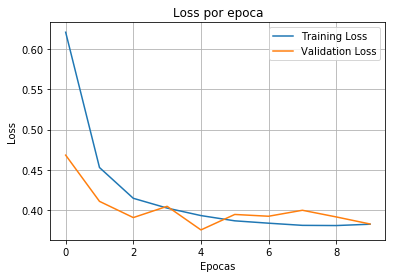

In [27]:
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.title("Loss por epoca")
plt.xlabel("Epocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)


Agora o certo seria pegar uma base de dados que a rede neural não viu ainda e realizar os testes, mas aqui iremos utilizar as ultimas 24 horas do mês de dezembro de 2016. Com estes dados vamos calcular o RMSE, MAPE, MBE e fazer graficos comparando a geração observada com a prevista

In [69]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [33]:
newData = dataFinal.tail(288)
newData.head()

,air_temp,relhum,press,windsp,winddir,max_windsp,precipitation,mes,hora,min,ghi
timeStamp,,,,,,,,,,,
2016-12-30 08:00:00,6.70,77.70,1008.0,0.96,93.50,1.9,0.0,12,8,0,0.0
2016-12-30 08:05:00,6.56,78.20,1008.0,1.24,79.35,2.0,0.0,12,8,5,0.0
2016-12-30 08:10:00,6.20,78.52,1008.0,0.92,39.37,1.8,0.0,12,8,10,0.0
2016-12-30 08:15:00,6.10,78.42,1008.0,1.00,203.00,1.4,0.0,12,8,15,0.0
2016-12-30 08:20:00,5.40,79.46,1008.0,1.32,186.50,2.0,0.0,12,8,20,0.0


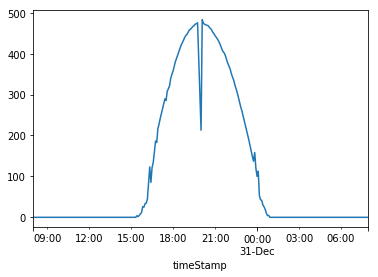

In [35]:
newData["ghi"].plot()

In [46]:
scaler = StandardScaler()
X = scaler.fit_transform(newData)
y = np.copy(X)

y = y[:,-1]
X = X[:,:-1]

X = torch.FloatTensor(X)
y = torch.FloatTensor(y).reshape(-1,1)

In [48]:
model.eval()
with torch.no_grad():
    y_hat = model(X)
    
xData = pd.DataFrame(X.numpy())
yData = pd.DataFrame(y_hat.numpy())
prevData = pd.concat([xData,yData], axis = 1)
prevData = scaler.inverse_transform(prevData)
prevData = pd.DataFrame(prevData,columns=['air_temp', 'relhum', 'press', 'windsp', 'winddir', 'max_windsp',
       'precipitation', 'mes','hora', 'min' ,'ghi'])


In [84]:
print(f"RMSE: {rmse_tensor(y,y_hat)}")
print(f"NRMSE: {nrmse_tensor(y,y_hat)}")
print(f"MAPE: {mape_tensor(y,y_hat)}")
print(f"MBE : {MBE_tensor(y,y_hat)}")
print(f"SCORE: {r2_score(y,y_hat)}")

RMSE: 0.2564707100391388
NRMSE: 0.08983495831489563
MAPE: 0.2872011065483093
MBE : 0.03023073449730873
SCORE: 0.9342227716767619


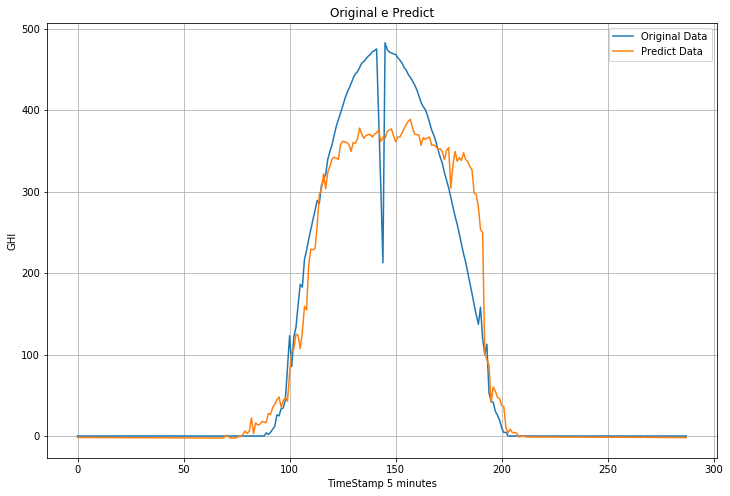

In [90]:
plt.figure(figsize = (12,8))
plt.plot(newData["ghi"].values, label = "Original Data")
plt.plot(prevData["ghi"].values, label = "Predict Data")
plt.title("Original e Predict")
plt.xlabel("TimeStamp 5 minutes")
plt.ylabel("GHI")
plt.legend()
plt.grid(True)

In [83]:
EPSILON = 1e-10
def _error_tensor(actual, predicted):
    """ Simple error """
    return actual - predicted


def _percentage_error_tensor(actual, predicted):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    
    return _error_tensor(actual, predicted) / (actual + EPSILON)

def mape_tensor(actual, predicted):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    
    return torch.mean(torch.abs(_percentage_error_tensor(actual, predicted)))

def mse_tensor(actual, predicted):
    """ Mean Squared Error """
    
    return torch.mean((_error_tensor(actual,predicted)).pow(2))


def rmse_tensor(actual, predicted):
    """ Root Mean Squared Error """
    
    return torch.sqrt(mse_tensor(actual, predicted))


def nrmse_tensor(actual, predicted):
    """ Normalized Root Mean Squared Error """
    
    return rmse_tensor(actual, predicted) / (actual.max() - actual.min())

def MBE_tensor(y_true, y_pred):
    '''
    Parameters:
        y_true (array): Array of observed values
        y_pred (array): Array of prediction values

    Returns:
        mbe (float): Biais score
    '''
    diff = (y_true-y_pred)
    mbe = diff.mean()
    return mbe

In [80]:
a = torch.tensor([2,3])

In [81]:
a

tensor([2, 3])

In [82]:
a.pow(2)

tensor([4, 9])